In [1]:
from mesa import Agent, Model
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx
import graph_init
import pandas as pd
import station as st

import network_example as ne
import numpy as np
import pathfinding as pf
import graph_functions as gf
import matplotlib.pyplot as plt
import Optimize_gradient_free as ogf
import model as m
import commuter as c
import bike_dist_hist as hist
import bike_dist_anim as anim

# Simulation
Run the simulation with this code using a basic network example graph. Use the histogram and animation functions to see the bike distribution

In [2]:
bike_distribution = {
    0:10,
    1:0,
    2:0,
    3:0
}

weights = [
    0.7,
    0.1,
    0.1,
    0.1
]

model = m.MyModel(100, seed=2, G=ne.basic_graph(capacity=10)[0], bike_init=bike_distribution, weights=weights)
for i in range(1000):
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()
pd.reset_option('display.max_rows', None)
agent_data[['Distance_Left', "Position", 'Intermediate_Node', 'Destination', 'All Station Capacity', 'Biking', 'Park Failures']]



Distance_Left  Position  Intermediate_Node  Destination  \
Step AgentID                                                            
0    1            15.000000         4                  0            6   
     2            36.000000         4                  5            5   
     3            15.000000         4                  0            7   
     4            60.000000         6                  4            4   
     5            36.000000         5                  4            4   
...                     ...       ...                ...          ...   
1000 96           27.000000         4                  7            7   
     97            1.000000         7                  4            4   
     98           12.107951         0                  7            7   
     99            1.000000         2                  4            4   
     100          35.000000         7                  4            4   

                   All Station Capacity  Biking  Park Failures  
Step AgentID                                                    
0    1        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
     2        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
     3        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
     4        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
     5        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
...                                 ...     ...            ...  
1000 96        {0: 1, 1: 2, 2: 0, 3: 0}   False              0  
     97        {0: 1, 1: 2, 2: 0, 3: 0}   False              0  
     98        {0: 1, 1: 2, 2: 0, 3: 0}   False              0  
     99        {0: 1, 1: 2, 2: 0, 3: 0}   False              0  
     100       {0: 1, 1: 2, 2: 0, 3: 0}   False              0  

[100100 rows x 7 columns]

MovieWriter imagemagick unavailable; using Pillow instead.


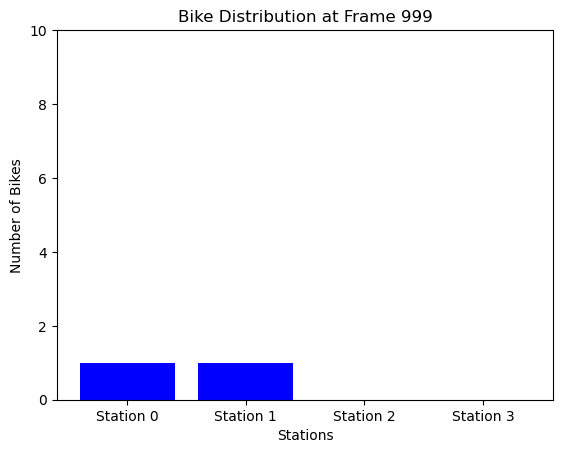

In [8]:
anim.animate(agent_data)

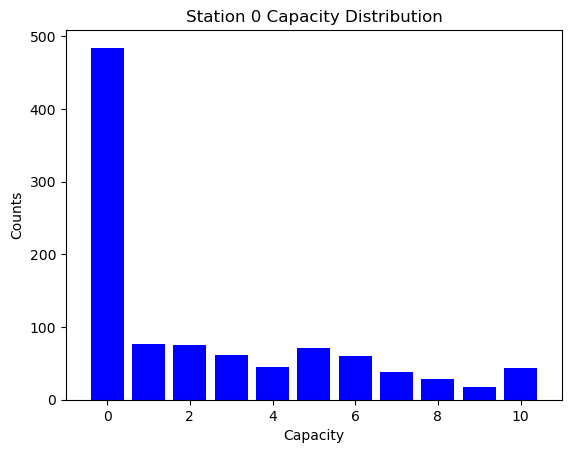

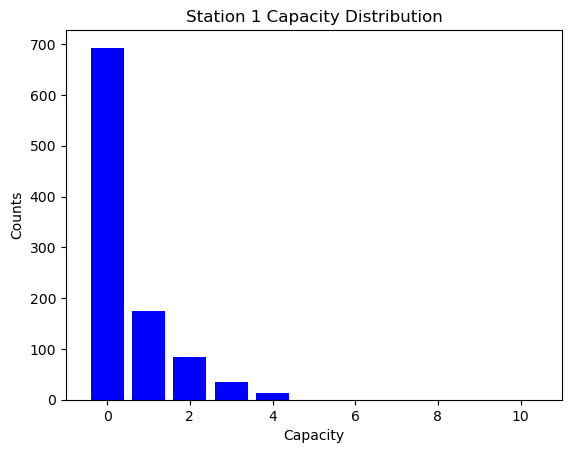

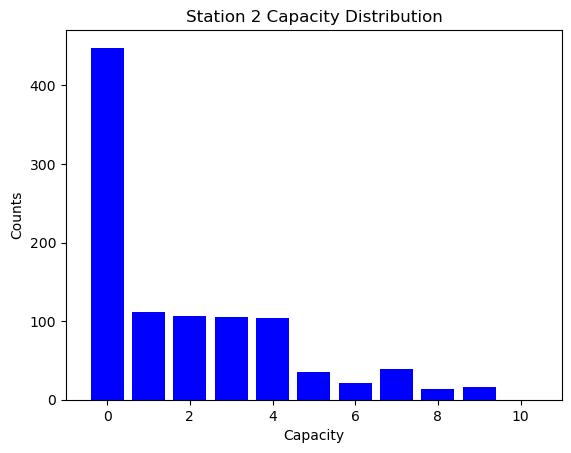

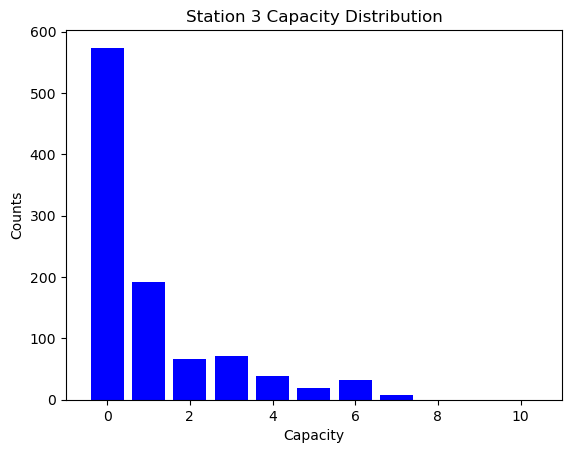

In [9]:
hist.hist(agent_data)

Generate an image of the network example graph which the above simulation uses

Station 0 has 3 bikes
Station 1 has 3 bikes
Station 2 has 3 bikes
Station 3 has 3 bikes


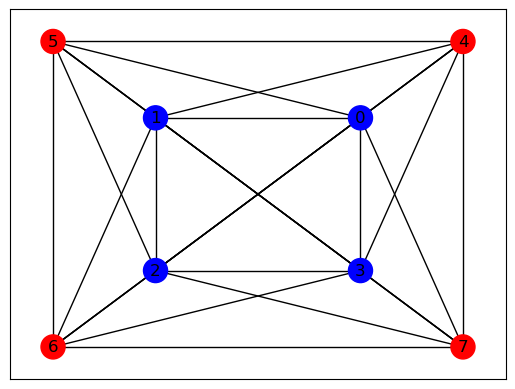

In [9]:
n_stations = 4
G, total_nodes = ne.basic_graph()
pos = {i: total_nodes[i] for i in range(total_nodes.shape[0])}
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, pos, node_color=colors, with_labels=True)
# print the number of bikes at each station
for i in range(n_stations):
    print('Station', i, 'has', G.nodes[i]['data'].available_bikes, 'bikes')

### Optimizer
Use the bottom cell to input some of the parameters such as the destination coordinates and the probability distribution for each destinations (weights)
- First let's start with a simple, 2 destination and 2 station graph

In [10]:
### parameters
destinations_coords = [
    (0, -4.5), 
    (0, 4.5), 
]

# weights for each destination (add up to 1)
w = [0.75, 0.25]

In [11]:
G,s,d = gf.create_graph_from_coordinates([], destinations_coords)

Visualize the initial destination graph, see which stations are which (adjust the draw network function to fit the destination coordinates)

{0: {'pos': (-4.5, 0), 'type': 'destination', 'data': None}, 1: {'pos': (4.5, 0), 'type': 'destination', 'data': None}}


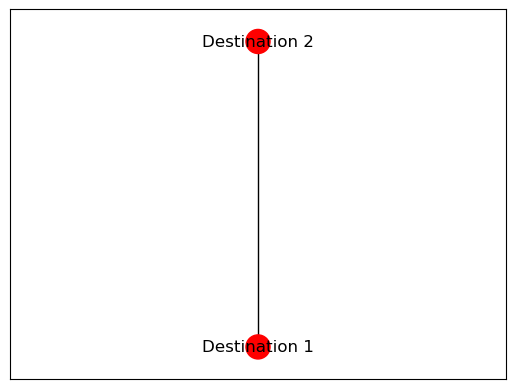

In [12]:
pos = {i: d["Destination " + str(i+1)] for i in range(len(d))}
print(pos)
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, {"Destination 1": [0, -4.5], "Destination 2": [0, 4.5]}, node_color = colors, with_labels=True)

Optimizer: 
- can use either genetic or PSO optimizer, just switch the optimizer
- also need to input destination coordinates here again
- adjust city map to fit the destination coords inside of it
- plots the loss curve
- second cell plots the optimized stations in the destination map

-4.5


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -3.0
Iteration 10: Best fitness: -3.6
Iteration 20: Best fitness: -3.75
Iteration 30: Best fitness: -3.9
Iteration 40: Best fitness: -3.9


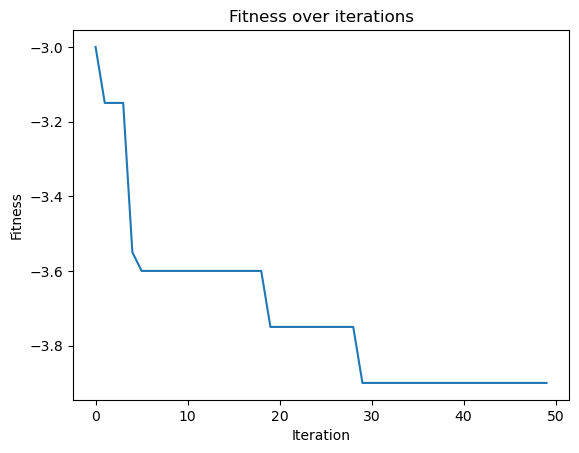

-3.9
[(-0.2557868985832984, 3.920611358793456), (-0.28140135167527575, -3.482077596315356)]


In [15]:
destinations = [i for i in G.nodes if G.nodes[i]['type'] == 'destination']

destinationcoords = [
    (0, -4.5), 
    (0, 4.5), 
]

G,s,d = gf.create_graph_from_coordinates([], destinationcoords)
citymap = [(-6,-6), (6,6)] + destinationcoords
def fitness(coordinatelist):
    destinations = coordinatelist["destination"]
    stations = coordinatelist["station"]
    G, s, d, = gf.create_graph_from_coordinates(stations, destinations)
    model = m.MyModel(20, seed=1, G=G, weights = w)
    for i in range(100):
        model.step()
    return model.walking_average()

print(fitness({"destination": destinationcoords, "station": destinationcoords}))

optimizer = ogf.Optimize(citymap, fitness, 0.7,1.4,1.4)
bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50)

## uncomment for genetic algorithm
# bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50, mutation_rate = 0.7, alpha = 0.3) 

optimizer.plot_losses()
print(bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
print(stations)
G, s, d, = gf.create_graph_from_coordinates(stations, destinationcoords)

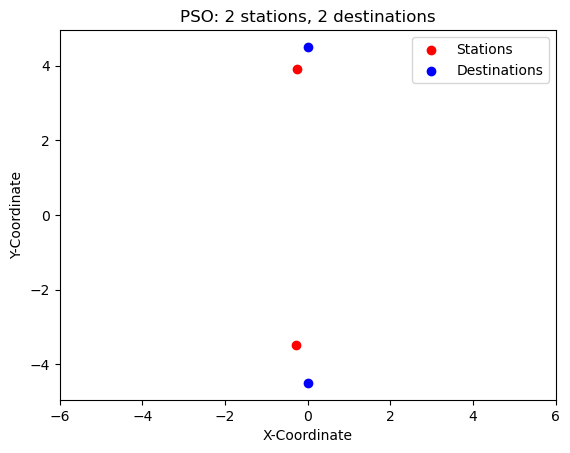

In [16]:
plt.scatter([station[0] for station in stations], [station[1] for station in stations], c='red', label='Stations')
plt.scatter([destination[0] for destination in destinationcoords], [destination[1] for destination in destinationcoords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6, 6)

plt.title('PSO: 2 stations, 2 destinations')
plt.legend()
# plt.savefig('PSO_2_2_2weight.png')
plt.show()

# Optimizer with 4 destinations, 2 stations
follows the same logic as before, but will change some parameters for additinal destinations

In [17]:
### parameters
destinations_coords = [
    (0, -4.5), 
    (0, 4.5), 
    (4.5,0),
    (-4.5,0)
]

# weights for each destination (add up to 1)
w = [0.7, 0.1, 0.1, 0.1]

In [18]:
G,s,d = gf.create_graph_from_coordinates([], destinations_coords)

{0: {'pos': (-4.5, 0), 'type': 'destination', 'data': None}, 1: {'pos': (4.5, 0), 'type': 'destination', 'data': None}, 2: {'pos': (0, 4.5), 'type': 'destination', 'data': None}, 3: {'pos': (0, -4.5), 'type': 'destination', 'data': None}}


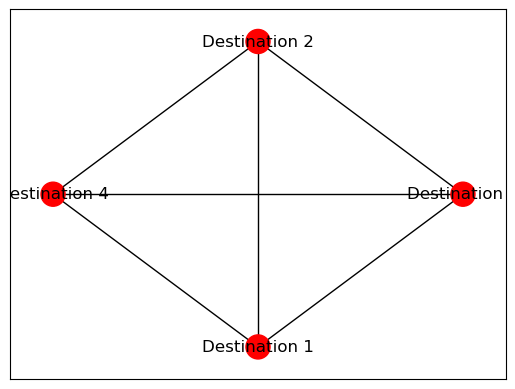

In [20]:
pos = {i: d["Destination " + str(i+1)] for i in range(len(d))}
print(pos)
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, {"Destination 1": [0, -4.5], "Destination 2": [0, 4.5], "Destination 3": [4.5, 0], "Destination 4": [-4.5,0]}, node_color = colors, with_labels=True)

-6.35


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -4.0
Iteration 10: Best fitness: -4.15
Iteration 20: Best fitness: -4.3
Iteration 30: Best fitness: -4.3
Iteration 40: Best fitness: -4.35


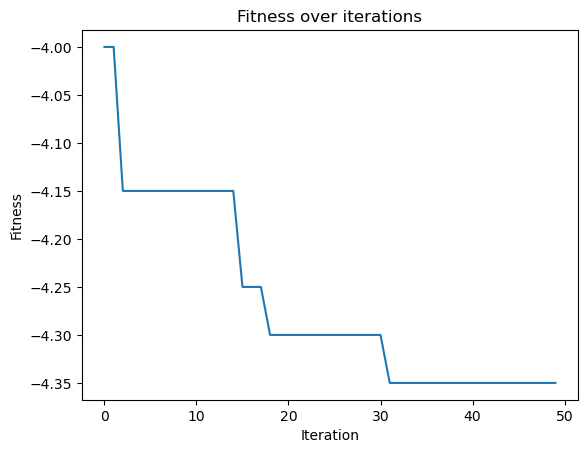

-4.35
[(4.5869619752587365, -0.3696042212240764), (0.227415370875743, -3.609740925010277)]


In [21]:
destinations = [i for i in G.nodes if G.nodes[i]['type'] == 'destination']

destinationcoords = [
    (0, -4.5), 
    (0, 4.5), 
    (4.5,0),
    (-4.5,0)
]

G,s,d = gf.create_graph_from_coordinates([], destinationcoords)
citymap = [(-6,-6), (6,6)] + destinationcoords
def fitness(coordinatelist):
    destinations = coordinatelist["destination"]
    stations = coordinatelist["station"]
    G, s, d, = gf.create_graph_from_coordinates(stations, destinations)
    model = m.MyModel(20, seed=1, G=G, weights = w)
    for i in range(100):
        model.step()
    return model.walking_average()

print(fitness({"destination": destinationcoords, "station": destinationcoords}))

optimizer = ogf.Optimize(citymap, fitness, 0.7,1.4,1.4)
bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50)

## uncomment for genetic algorithm
# bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50, mutation_rate = 0.7, alpha = 0.3) 

optimizer.plot_losses()
print(bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
print(stations)
G, s, d, = gf.create_graph_from_coordinates(stations, destinationcoords)

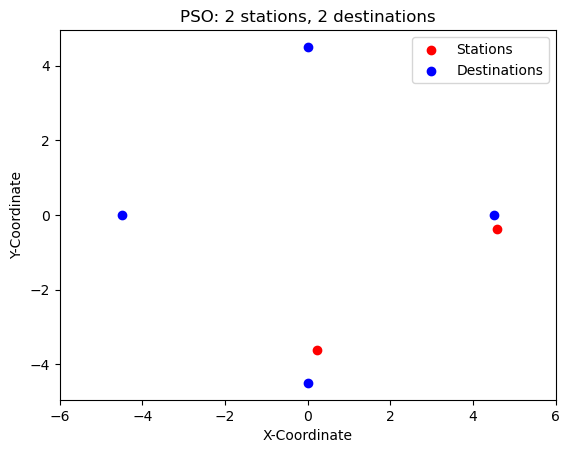

In [22]:
plt.scatter([station[0] for station in stations], [station[1] for station in stations], c='red', label='Stations')
plt.scatter([destination[0] for destination in destinationcoords], [destination[1] for destination in destinationcoords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6, 6)

plt.title('PSO: 2 stations, 2 destinations')
plt.legend()
# plt.savefig('PSO_2_2_2weight.png')
plt.show()

Using this implementation, run with different number of destinations and stations. Next, let's optimize UT's map
### UT map optimization

Average edge length (TOTAL): 5.284430560802597
Minimum edge length (TOTAL): 0.9316949906211162
Maximum edge length (TOTAL): 10.906165432654499




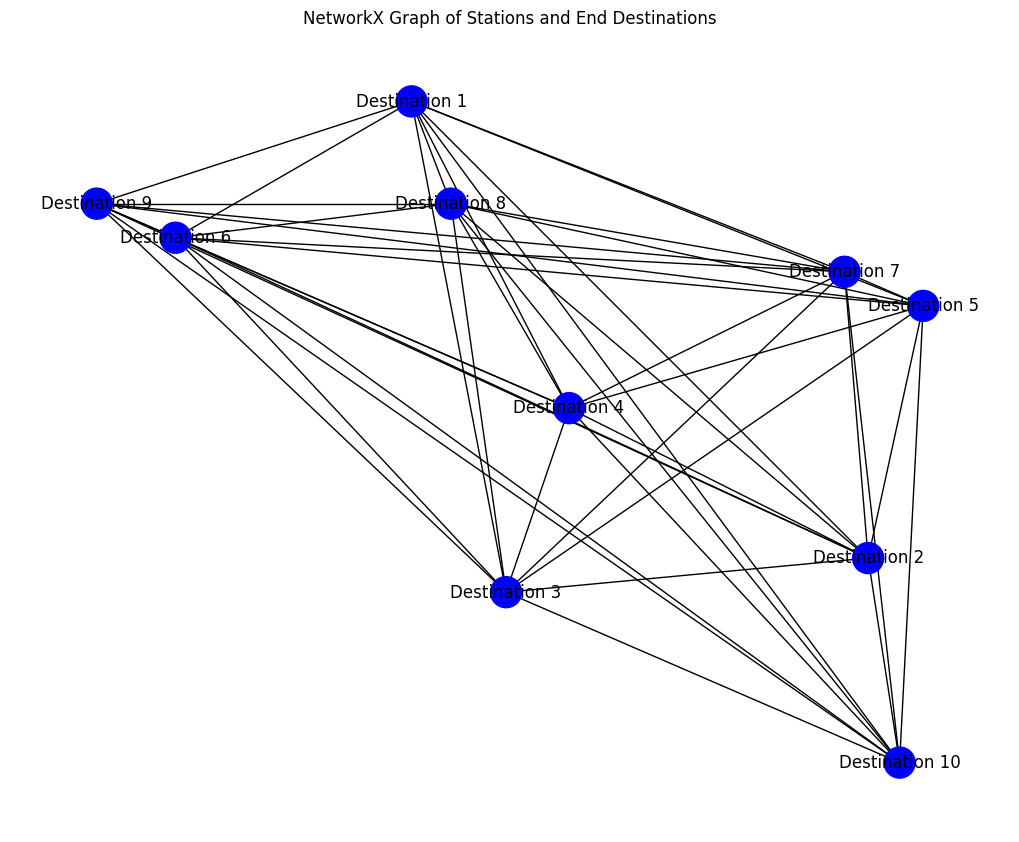

In [22]:
# stations_coords = [
#     (30.29068, -97.74292), #Nueces & 26th
#     (30.283, -97.7375), # 21st & Speedway PCL
#     (30.28395, -97.74198), # Guadalupe & 21st
#     (30.28576, -97.74181), # UT West Mall @ Guad
#     (30.28953, -97.73695), # Dean Keeton & Speedway
#     (30.2874, -97.7478), # 23rd & San Gabriel

#     (30.28354, -97.73953), # 21st & University
#     (30.2862, -97.74516), # 22nd 1/2 Rio Grande
#     (30.2853, -97.7467), # 22nd & Pearl
#     (30.29333, -97.74412), # Rio Grande & 28th
#     (30.2898, -97.74041), # Dean Keeton & Whitis
#     (30.2856, -97.7335) # 23rd San Jac @ DKR Stadium
# ]

#destination points (picked out by me, subject to change)
destinationcoords = [
    (30.2910, -97.7430), #26 West
    (30.2843, -97.7372), #McCombs
    (30.2838, -97.7418), #Target
    (30.2865, -97.7410), #Union Building
    (30.2880, -97.7365), #PMA
    (30.2890, -97.7460), #Union on 24th

    (30.2885, -97.7375), #Welch
    (30.2895, -97.7425), #Rise
    (30.2895, -97.7470), #Axis West
    (30.2813, -97.7368) #Rec
]

norm_stations, norm_destinations = gf.normalize_coords(stations_coords, destinationcoords)
# Usage after creating the graph
G, station_nodes, end_destination_nodes = gf.create_graph_from_coordinates([], norm_destinations)
average_edge_length = gf.calculate_average_edge_length(G)
min_edge_length = gf.calculate_minimum_edge_length(G)
max_edge_length = gf.calculate_maximum_edge_length(G)

print(f"Average edge length (TOTAL): {average_edge_length}")
print(f"Minimum edge length (TOTAL): {min_edge_length}")
print(f"Maximum edge length (TOTAL): {max_edge_length}")
print()
print()

pos = nx.get_node_attributes(G, 'pos')

node_colors = ['red' if G.nodes[node]['type'] == 'station' else 'blue' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors)
plt.title("NetworkX Graph of Stations and End Destinations")
plt.show()

-11.6


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -6.6
Iteration 10: Best fitness: -6.75
Iteration 20: Best fitness: -7.0
Iteration 30: Best fitness: -7.0
Iteration 40: Best fitness: -7.0


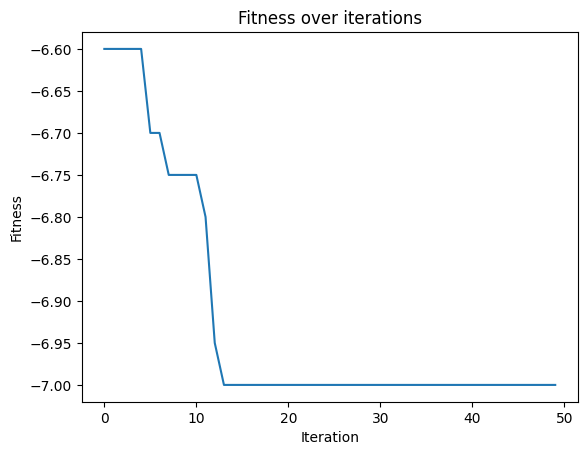

-7.0
[(5.405759412035847, 0.034803413795078786), (1.6319036985872377, -3.9769369292682866), (1.5025453109473803, 2.7925065080015004), (0.1258887667128734, 4.480600751647373), (-3.3756861801130262, -0.07035854530151875), (0.10870161913108034, -5.3073303267119245)]
[ 5.40575941  0.03480341  1.6319037  -3.97693693  1.50254531  2.79250651
  0.12588877  4.48060075 -3.37568618 -0.07035855  0.10870162 -5.30733033]


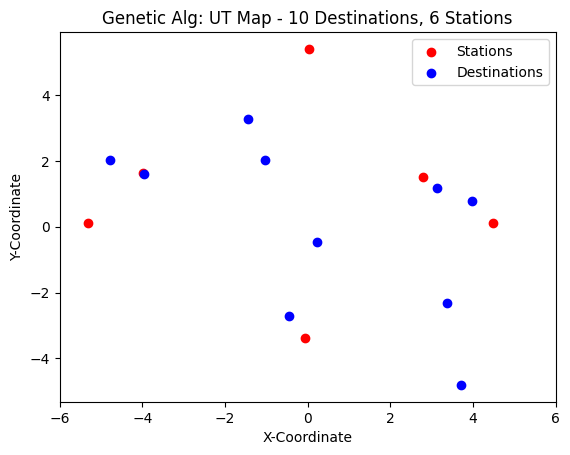

In [23]:
destinations = [i for i in G.nodes if G.nodes[i]['type'] == 'destination']

#destinationcoords = [(pos[i][0], pos[i][1]) for i in destinations]
destinationcoords = [(3.2768939393972687, -1.4515151515224716), (-2.306439393934852, 3.381818181806011), (-2.7231060606027313, -0.45151515152247157), (-0.4731060606027313, 0.21515151514904574), (0.7768939393972687, 3.965151515134494), (1.6102272727293894, -3.9515151515224716), (1.193560606065148, 3.131818181806011), (2.0268939393972687, -1.0348484848655062), (2.0268939393972687, -4.784848484850954), (-4.806439393934852, 3.7151515151490457)]

#destinationlist = np.array([[pos[i][0], pos[i][1]] for i in destinations])
G,s,d = gf.create_graph_from_coordinates([], destinationcoords)
citymap = [(-6,-6), (6,6)] + destinationcoords
w = gf.weights()
def fitness(coordinatelist):
    destinations = coordinatelist["destination"]
    stations = coordinatelist["station"]
    G, s, d, = gf.create_graph_from_coordinates(stations, destinations)
    model = m.MyModel(20, seed=1, G=G, weights = w)
    for i in range(100):
        model.step()
    return model.walking_average()

print(fitness({"destination": destinationcoords, "station": destinationcoords}))

optimizer = ogf.Optimize(citymap, fitness, 0.7,1.4,1.4)
bestpos, bestfit = optimizer.optimize_genetic(20, 6, 50, mutation_rate = 0.7, alpha = 0.3)

optimizer.plot_losses()
print(bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
print(stations)
G, s, d, = gf.create_graph_from_coordinates(stations, destinationcoords)
print(bestpos)

plt.scatter([station[1] for station in stations], [station[0] for station in stations], c='red', label='Stations')
plt.scatter([destination[1] for destination in destinationcoords], [destination[0] for destination in destinationcoords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6,6)

plt.title('Genetic Alg: UT Map - 10 Destinations, 6 Stations')
plt.legend()
plt.show()

-11.6


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -6.55
Iteration 10: Best fitness: -6.9
Iteration 20: Best fitness: -7.15
Iteration 30: Best fitness: -7.15
Iteration 40: Best fitness: -7.3


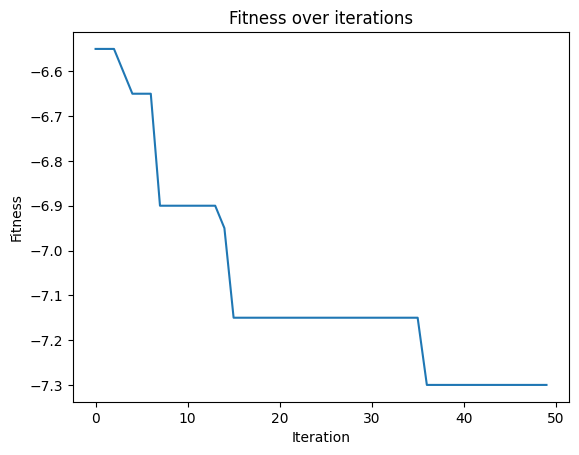

-7.3
[(-4.48231793409009, -2.8397894822999046), (-1.7013100458253518, -4.80348264245101), (-3.0036759793574674, -0.003071543646319695), (1.4441476695977995, 3.2665946292100374), (0.13390283893123833, -2.0460102440790586), (1.7744529661697515, -4.45336514267218)]
[-4.48231793e+00 -2.83978948e+00 -1.70131005e+00 -4.80348264e+00
 -3.00367598e+00 -3.07154365e-03  1.44414767e+00  3.26659463e+00
  1.33902839e-01 -2.04601024e+00  1.77445297e+00 -4.45336514e+00]


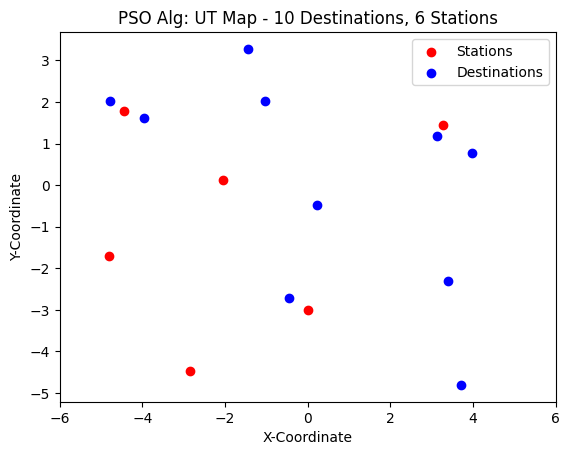

In [24]:
destinations = [i for i in G.nodes if G.nodes[i]['type'] == 'destination']

#destinationcoords = [(pos[i][0], pos[i][1]) for i in destinations]
destinationcoords = [(3.2768939393972687, -1.4515151515224716), (-2.306439393934852, 3.381818181806011), (-2.7231060606027313, -0.45151515152247157), (-0.4731060606027313, 0.21515151514904574), (0.7768939393972687, 3.965151515134494), (1.6102272727293894, -3.9515151515224716), (1.193560606065148, 3.131818181806011), (2.0268939393972687, -1.0348484848655062), (2.0268939393972687, -4.784848484850954), (-4.806439393934852, 3.7151515151490457)]

#destinationlist = np.array([[pos[i][0], pos[i][1]] for i in destinations])
G,s,d = gf.create_graph_from_coordinates([], destinationcoords)
citymap = [(-6,-6), (6,6)] + destinationcoords
w = gf.weights()
def fitness(coordinatelist):
    destinations = coordinatelist["destination"]
    stations = coordinatelist["station"]
    G, s, d, = gf.create_graph_from_coordinates(stations, destinations)
    model = m.MyModel(20, seed=1, G=G, weights = w)
    for i in range(100):
        model.step()
    return model.walking_average()

print(fitness({"destination": destinationcoords, "station": destinationcoords}))

optimizer = ogf.Optimize(citymap, fitness, 0.7,1.4,1.4)
bestpos, bestfit = optimizer.optimize_PSO(20, 6, 50)
optimizer.plot_losses()
print(bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
print(stations)
G, s, d, = gf.create_graph_from_coordinates(stations, destinationcoords)
print(bestpos)

plt.scatter([station[1] for station in stations], [station[0] for station in stations], c='red', label='Stations')
plt.scatter([destination[1] for destination in destinationcoords], [destination[0] for destination in destinationcoords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6, 6)

plt.title('PSO Alg: UT Map - 10 Destinations, 6 Stations')
plt.legend()
plt.show()